In [9]:
import numpy as np
import pandas as pd
import pyreadr
import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
# define paths
data_path = '/Users/simonneumeyer/Dropbox/Ethiopia IE - Road Safety/Data/'
crashes_path = 'ETRE - Crashes/'
crash_file = 'FinalData/crashes.csv'
traffic_path = 'ETRE - Traffic/'
traffic_file = 'FinalData/traffic.pq'
precipitation_path = 'Precipitation/'
precipitation_file = 'FinalData/precipitation.csv'

In [3]:
segment_time = pd.read_parquet(data_path + 'Time Segment Data/segment_time_panel.pq', engine='pyarrow')

In [4]:
segment_time[['total_weight', 'avg_weight_tons', 'log_avg_weight_tons', 'speed_km_hr', 
        'veh_type_1', 'veh_type_2', 'veh_type_3', 'veh_type_4', 'veh_type_5', 'veh_type_6', 'veh_type_7', 
        'speed_rain', 'speed_low_traffic_and_rain', 'speed_low_traffic_p25']] = segment_time[['total_weight', 'avg_weight_tons', 'log_avg_weight_tons', 'speed_km_hr', 
        'veh_type_1', 'veh_type_2', 'veh_type_3', 'veh_type_4', 'veh_type_5', 'veh_type_6', 'veh_type_7', 
        'speed_rain', 'speed_low_traffic_and_rain', 'speed_low_traffic_p25']].fillna(0)

In [5]:
segment_time.columns

Index(['index', 'date', 'hour', 'km_from_addis', 'direction', 'accidents',
       'precip_mm', 'vehicle_type', 'vehicle_brand', 'road_geometry',
       ...
       'rain_seg_4', 'rain_seg_5', 'rain_seg_6', 'low_traffic_dummy_p25',
       'speed_low_traffic_p25', 'rain_dummy', 'speed_rain',
       'speed_low_traffic_and_rain', 'avg_weight_tons', 'log_avg_weight_tons'],
      dtype='object', length=131)

# Regression:

In [6]:
cols = ['k_cars', 'weekend', 
        'holiday', 'holiday_plusminus_2day', 'speed_p90', 'rush_hour_dummy', 'avg_weight_tons', 
        'veh_type_1', 'veh_type_3', 'veh_type_4', 'veh_type_5', 'veh_type_6', 'veh_type_7', 
        'speed_rain', 'midnight_dummy', 
        'rain_seg_1', 'rain_seg_2', 'rain_seg_3', 'rain_seg_4', 'rain_seg_5', 'rain_seg_6']

## OLS:

In [7]:
# OLS model:

# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()
y = df.accidents

X = df[cols]
X = sm.add_constant(X)

# for clustered se option
groups = df.km_from_addis

# Fit and summarize OLS model
model = sm.OLS(y, X)

linreg = model.fit()
#linreg = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:              accidents   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     21.81
Date:                Thu, 17 Jun 2021   Prob (F-statistic):           8.85e-84
Time:                        13:57:58   Log-Likelihood:             1.1463e+07
No. Observations:             3926853   AIC:                        -2.293e+07
Df Residuals:                 3926831   BIC:                        -2.293e+07
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.71

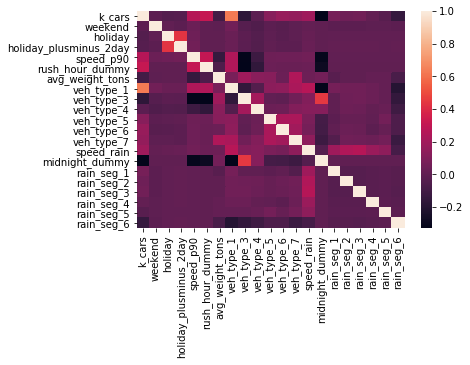

In [8]:
# check for correlation between covariates:
corr = np.corrcoef(X.T[1:])
sns.heatmap(corr, xticklabels=X.columns[1:], yticklabels=X.columns[1:])
plt.show()

## Fixed Effects:

### year fixed effects:

In [18]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()

# create year and month variable:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

# set index:
df = df.set_index(['year', 'month']).sort_index()
y = df.accidents

X = df[cols]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.3305
No. Observations:             3926853   R-squared (Within):               0.0001
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:22:07   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.793
Entities:                           3   P-value                           0.0000
Avg Obs:                    1.309e+06   Distribution:              F(21,3926829)
Min Obs:                    1.157e+06                                           
Max Obs:                    1.386e+06   F-statistic (robust):          1.463e+16
                            

### year month fixed effects:

In [19]:
mod = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.2840
No. Observations:             3926853   R-squared (Within):               0.0001
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:22:59   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      19.926
Entities:                           3   P-value                           0.0000
Avg Obs:                    1.309e+06   Distribution:              F(21,3926818)
Min Obs:                    1.157e+06                                           
Max Obs:                    1.386e+06   F-statistic (robust):         -2.183e+16
                            

### Month fixed effects:

In [20]:
mod = PanelOLS(y, X, time_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='clustered', cluster_time=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.3969
No. Observations:             3926853   R-squared (Within):               0.0001
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:23:39   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.945
Entities:                           3   P-value                           0.0000
Avg Obs:                    1.309e+06   Distribution:              F(21,3926820)
Min Obs:                    1.157e+06                                           
Max Obs:                    1.386e+06   F-statistic (robust):          6.486e+15
                            

### Segment Fixed Effects:

In [21]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()

df = df.set_index(['km_from_addis', 'date']).sort_index()
y = df.accidents

X = df[cols]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                     6.508e-05
Estimator:                   PanelOLS   R-squared (Between):              0.2485
No. Observations:             3926853   R-squared (Within):            6.508e-05
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:25:01   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.170
Entities:                          79   P-value                           0.0000
Avg Obs:                    4.971e+04   Distribution:              F(21,3926753)
Min Obs:                    4.971e+04                                           
Max Obs:                    4.971e+04   F-statistic (robust):             4.8435
                            

### Year-month-day Fixed Effects:

In [22]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()

df = df.set_index(['km_from_addis', 'date']).sort_index()
y = df.accidents

X = df[cols]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=False, time_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='clustered', cluster_time=True)
print(res)

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/linearmodels/panel/model.py:1798: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

weekend, holiday, holiday_plusminus_2day, rain_seg_6

  AbsorbingEffectWarning,


                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.3486
No. Observations:             3926853   R-squared (Within):            5.878e-05
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:26:35   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      23.964
Entities:                          79   P-value                           0.0000
Avg Obs:                    4.971e+04   Distribution:              F(17,3925799)
Min Obs:                    4.971e+04                                           
Max Obs:                    4.971e+04   F-statistic (robust):             20.489
                            

### Segment-Direction Fixed Effects:


In [23]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()

df = df.set_index(['direction', 'km_from_addis']).sort_index()
y = df.accidents

X = df[cols]
X = sm.add_constant(X)

mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              accidents   R-squared:                      6.58e-05
Estimator:                   PanelOLS   R-squared (Between):             -12.077
No. Observations:             3926853   R-squared (Within):               0.0001
Date:                Fri, Jun 11 2021   R-squared (Overall):              0.0001
Time:                        13:28:10   Log-likelihood                 1.146e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.305
Entities:                           2   P-value                           0.0000
Avg Obs:                    1.963e+06   Distribution:              F(21,3926752)
Min Obs:                    1.963e+06                                           
Max Obs:                    1.963e+06   F-statistic (robust):         -3.371e+15
                            

## Logistic Regression:

In [24]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()
y = df.accidents
X = df[cols]

import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
#print(sm_model.pvalues)
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              accidents   No. Observations:              3926853
Model:                          Logit   Df Residuals:                  3926831
Method:                           MLE   Df Model:                           21
Date:                Fri, 11 Jun 2021   Pseudo R-squ.:                 0.03331
Time:                        13:29:18   Log-Likelihood:                -6267.0
converged:                       True   LL-Null:                       -6482.9
Covariance Type:            nonrobust   LLR p-value:                 2.344e-78
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11.2516      0.329    -34.211      0.000     -11.896     -10.607
k_cars                     1.7288      0.202      8.551      0.000       1.332       2.125
weekend                    0.0631      0.079      0.804      0.422      -0.091       0.217
holiday                   -0.2556      0.252     -1.013      0.311      -0.750       0.239
holiday_plusminus_2day     0.1419      0.113      1.261      0.207      -0.079       0.362
speed_p90                  0.0031      0.002      1.395      0.163      -0.001       0.007
rush_hour_dummy            0.8014      0.096      8.351      0.000       0.613       0.989
avg_weight_tons           -0.0135      0.011     -1.188      0.235      -0.036       0.009
veh_type_1                 1.9124      0.325      5.888      0.000       1.276       2.549
veh_type_3                 1.7719      0.280      6.330      0.000       1.223       2.320
veh_type_4                 1.5518      0.409      3.792      0.000       0.750       2.354
veh_type_5                 0.8648      2.059      0.420      0.674      -3.170       4.900
veh_type_6                 0.9038      2.610      0.346      0.729      -4.211       6.019
veh_type_7                 0.8147      0.644      1.264      0.206      -0.448       2.078
speed_rain                 0.0025      0.001      2.369      0.018       0.000       0.004
midnight_dummy             0.7710      0.143      5.373      0.000       0.490       1.052
rain_seg_1                 0.3731      0.093      4.026      0.000       0.191       0.555
rain_seg_2                 0.2375      0.113      2.100      0.036       0.016       0.459
rain_seg_3                -0.3078      0.190     -1.619      0.106      -0.681       0.065
rain_seg_4                -0.7182      0.403     -1.784      0.074      -1.507       0.071
rain_seg_5                -1.1922      0.794     -1.501      0.133      -2.749       0.365
rain_seg_6                 0.1830      0.297      0.616      0.538      -0.399       0.765
==========================================================================================

Possibly complete quasi-separation: A fraction 0.35 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Random Forest:

In [25]:
# dropping NAs where we don't have speed_mean (only 8k observations)
df = segment_time.dropna(subset=['speed_mean']).reset_index()

y = df.accidents
X = df[cols]

In [26]:
%%time
regr = RandomForestClassifier(max_depth=2, random_state=0)
regr.fit(X, y)

CPU times: user 3min 3s, sys: 6.33 s, total: 3min 10s
Wall time: 3min 16s


RandomForestClassifier(max_depth=2, random_state=0)

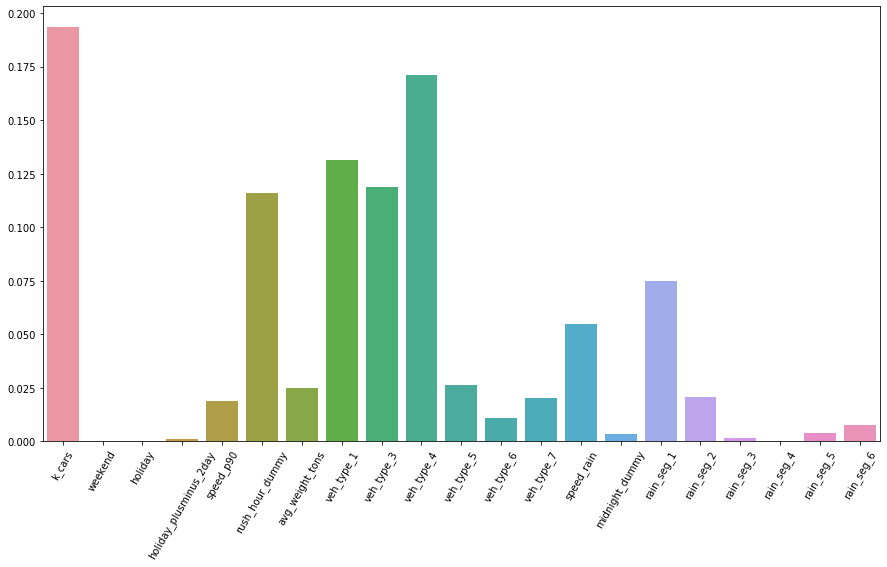

In [27]:
plt.figure(figsize=(15,8))
sns.barplot(x=X.columns, y=regr.feature_importances_)
plt.xticks(rotation=60)
plt.show()